## Objective -- reproject a raster image onto a large domain

Take 600 x 600 image and reproject it onto an 800 x 600 domain with
larger lat/lon extent

In [1]:
from e582utils.data_read import download

import numpy as np
import warnings
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import seaborn as sns
from e582lib.map_slices import  make_basemap_xy
import pyproj
from rasterio.warp import reproject, Resampling
warnings.filterwarnings("ignore")

#### Use this pallete to show points

In [2]:
cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('r')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('w',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

### Do the transformation using rasterio

#### step 1  -- define the raster transform and the projection for the small image

In [3]:
%matplotlib inline
sea_lon,sea_lat= -122.3321,47.6062
van_lon,van_lat = -123.2460,49.2606
van_crs={'datum': 'WGS84', 'lat_0': van_lat, 'lon_0': van_lon, 'proj': 'laea', 'units': 'm'}
van_proj=pyproj.Proj(van_crs)
van_ll_lat=40.
van_ll_lon=-135
van_ur_lat=55.0
van_ur_lon=-110
van_ll_x,van_ll_y=van_proj(van_ll_lon,van_ll_lat)
van_ur_x,van_ur_y=van_proj(van_ur_lon,van_ur_lat)
van_height,van_width=600,600
from rasterio.transform import from_bounds
van_transform = from_bounds(van_ll_x, van_ll_y, van_ur_x, van_ur_y, van_width, van_height)

#### step 2-- create a fake image with seattle and vancouver as red and green points and the corners marked with black squares

In [4]:
x_sea,y_sea=van_proj(sea_lon,sea_lat)
col_sea,row_sea=~van_transform*(x_sea,y_sea)
col_sea,row_sea = int(col_sea),int(row_sea)
x_van,y_van=van_proj(van_lon,van_lat)
col_van,row_van=~van_transform*(x_van,y_van)
col_van,row_van = int(col_van),int(row_van)
van_image=np.empty([van_height,van_width],dtype=np.float32)
van_image[...]=np.nan
van_image[row_sea:row_sea+10,col_sea:col_sea+10]=5.  #red
van_image[row_van:row_van+10,col_van:col_van+10]=0.8 #green
van_image[0:10,0:10]=-1  #black
van_image[-10:,-10:]=-1
van_image[0:10,0:10]=-1
van_image[0:10,-10:]=-1
van_image[-10:,0:10]=-1

#### step 3: plot the small image with basemap

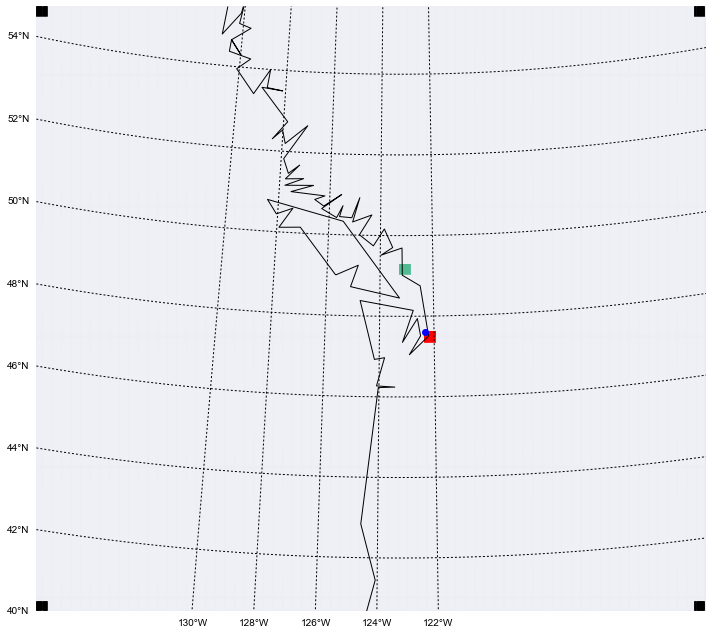

In [5]:
ll_dict=dict(llcrnrlat=van_ll_lat,llcrnrlon=van_ll_lon,urcrnrlat=van_ur_lat,
                  urcrnrlon=van_ur_lon)
basemap_args={k:van_crs[k] for k in ['lat_0','lon_0']}
basemap_args['projection'] = 'laea'
basemap_args['ellps']='WGS84'
basemap_args.update(ll_dict)


fig,ax=plt.subplots(1,1,figsize=(12,12))
basemap_args['ax']=ax
basemap_args['resolution']='c'
van_masked=np.ma.masked_invalid(van_image)
bmap_small=Basemap(**basemap_args)
xsea,ysea=bmap_small(sea_lon,sea_lat)
xvals,yvals=make_basemap_xy(0,van_height,0,van_width,bmap_small,van_transform)
bmap_small.pcolormesh(xvals,yvals,van_masked,cmap=cmap,norm=the_norm);
bmap_small.drawcoastlines()
bmap_small.plot(xsea,ysea,'bo')
parallels=np.arange(40, 60, 2)
meridians=np.arange(-130, -120,2)
bmap_small.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap_small.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);



#### step 4:  do the reprojection -- to a domain with greater area on a bigger grid using rasterio



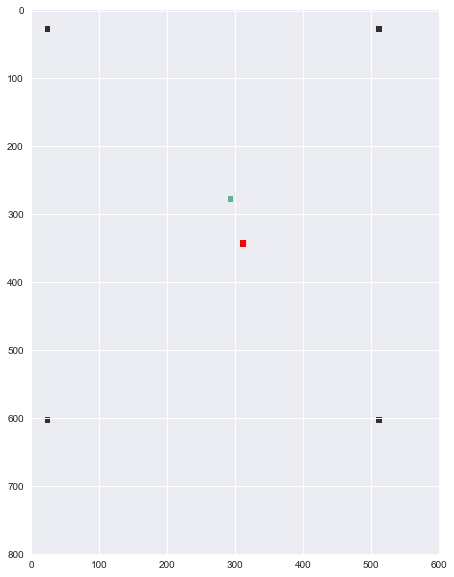

In [6]:
new_ll_lat=35.
new_ll_lon=-135
new_ur_lat=55.0
new_ur_lon=-105
new_ll_x,new_ll_y=van_proj(new_ll_lon,new_ll_lat)
new_ur_x,new_ur_y=van_proj(new_ur_lon,new_ur_lat)
new_height,new_width=800,600
from rasterio.transform import from_bounds
large_transform = from_bounds(new_ll_x, new_ll_y, new_ur_x, new_ur_y, new_width, new_height)

new_image = np.empty([new_height, new_width],dtype=np.float32)
fill_value = np.nan
new_image[...] = fill_value
out = reproject(van_image,new_image,src_transform=van_transform,src_crs=van_crs,src_nodata=fill_value,dst_nodata=fill_value,
                    dst_transform=large_transform,dest_crs=van_crs,resampling=Resampling.nearest)

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(new_image,origin='upper',cmap=cmap,norm=the_norm);

#### step 5: plot the new image using basemap

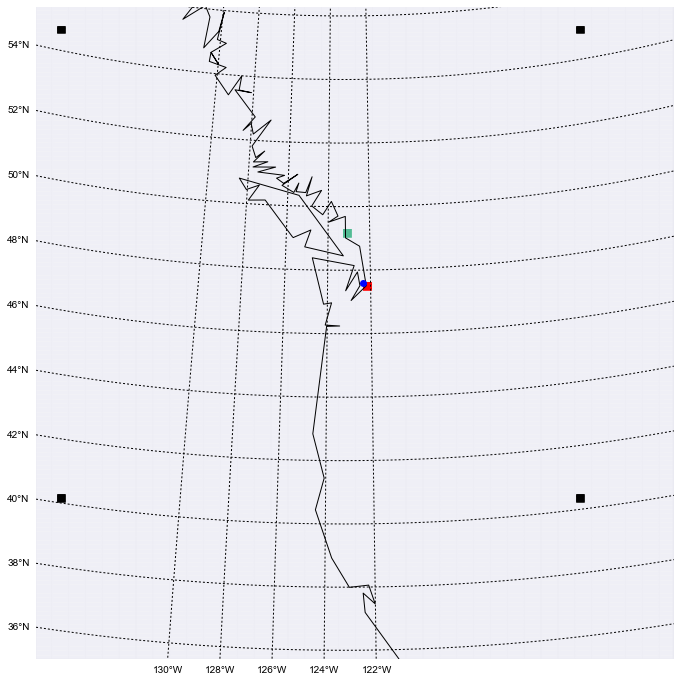

In [7]:
ll_dict=dict(llcrnrlat=new_ll_lat,llcrnrlon=new_ll_lon,urcrnrlat=new_ur_lat,
                  urcrnrlon=new_ur_lon)
large_basemap_args={k:van_crs[k] for k in ['lat_0','lon_0']}
large_basemap_args['projection'] = 'laea'
large_basemap_args['ellps']='WGS84'
large_basemap_args.update(ll_dict)

new_height,new_width=new_image.shape
fig,ax=plt.subplots(1,1,figsize=(12,12))
large_basemap_args['ax']=ax
large_basemap_args['resolution']='c'
bmap_large=Basemap(**large_basemap_args)
xvals,yvals=make_basemap_xy(0,new_height,0,new_width,bmap_large,large_transform)
new_masked = np.ma.masked_invalid(new_image)
bmap_large.pcolormesh(xvals,yvals,new_masked,cmap=cmap,norm=the_norm);
#bmap_large.imshow(new_image,cmap=cmap,norm=the_norm,origin='upper')
bmap_large.drawcoastlines();
parallels=np.arange(30, 60, 2)
meridians=np.arange(-130, -120,2)
bmap_large.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap_large.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);
xsea,ysea=bmap_large(sea_lon,sea_lat)
bmap_large.plot(xsea,ysea,'bo');

### Repeat using pyresample

#### step 1: setup up the crs and corners for the small and large images

In [8]:
from pyresample import image, geometry
small_crs=bmap_small.projparams
small_extent=[bmap_small.llcrnrx,bmap_small.llcrnry,bmap_small.urcrnrx,bmap_small.urcrnry]
small_height,small_width = van_image.shape
large_crs=bmap_large.projparams
large_extent=[bmap_large.llcrnrx,bmap_large.llcrnry,bmap_large.urcrnrx,bmap_large.urcrnry]
large_height,large_width = 800,600

#### step 2: reproject utins pyresample

see http://pyresample.readthedocs.io/en/latest/grid.html

In [9]:
from_image = van_image
from_def = geometry.AreaDefinition('small', 'small image', 'area_small',
                               small_crs,
                               small_width, small_height,
                               small_extent)
to_def = geometry.AreaDefinition('big', 'big image','area_big',
                               large_crs,
                               large_width,large_height,
                               large_extent)

from_nn = image.ImageContainerNearest(van_image,from_def, radius_of_influence=5000)
to_nn = from_nn.resample(to_def)
result_data_nn = to_nn.image_data

#### step 3: plot using basemap

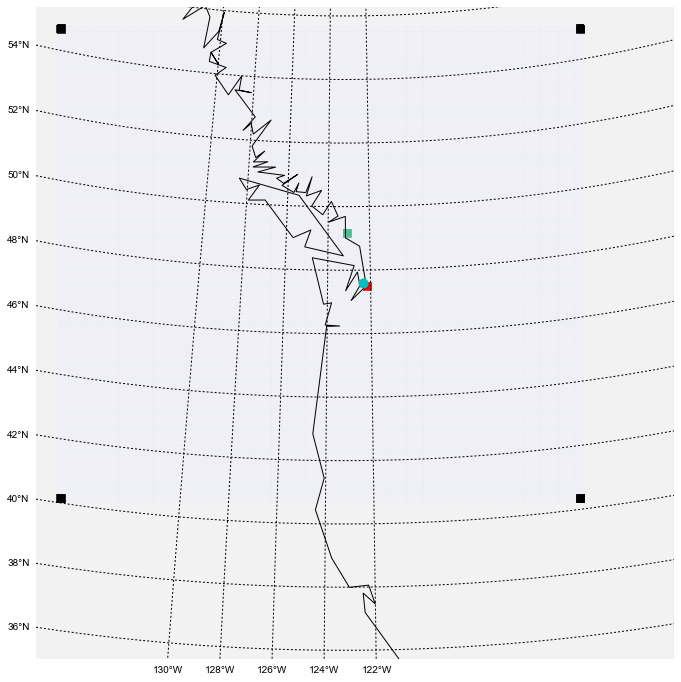

In [10]:
result_masked=np.ma.masked_invalid(result_data_nn)
fig,ax = plt.subplots(1,1,figsize=(12,12))
large_basemap_args['ax']=ax
large_basemap_args['resolution']='c'
bmap_large=Basemap(**large_basemap_args)
xvals,yvals=make_basemap_xy(0,large_height,0,large_width,bmap_large,large_transform)
#bmap_large.imshow(result_data_nn,cmap=cmap,norm=the_norm,origin='upper')
bmap_large.pcolormesh(xvals,yvals,result_masked,cmap=cmap,norm=the_norm);
x_sea,y_sea=bmap_large(sea_lon,sea_lat)
bmap_large.plot(x_sea,y_sea,'co',markersize=10)
bmap_large.drawcoastlines();
parallels=np.arange(30, 60, 2)
meridians=np.arange(-130, -120,2)
bmap_large.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap_large.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);